# Pruebas

## Para las pruebas se usara datos en 2D, donde mostraremos la eficiencia de agrupamiento de Spectral Clustering

In [42]:
import time
import numpy as np
import pylab as pl
from sklearn import cluster, datasets
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

Generando datos de manera automatica, defidiendo antes el numero de puntos.

In [43]:
n_samples = 750
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

pl.figure(figsize=(14, 9.5))
pl.subplots_adjust(left=.001, right=.999, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

## Graficando data

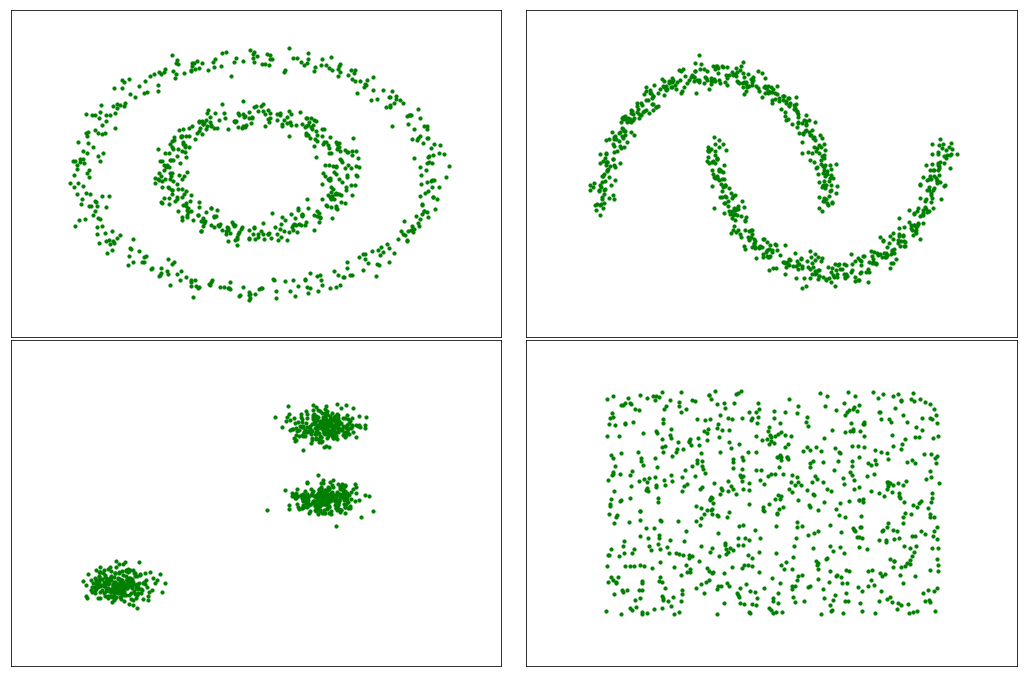

In [44]:
datasets = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # Normalizando datos para una facil seleccion de parametros
    X = StandardScaler().fit_transform(X)
    # plot
    pl.subplot(2, 2, plot_num)
    pl.scatter(X[:, 0], X[:, 1], color='g', s=10)

    pl.xlim(-2.5, 2.5)
    pl.ylim(-2.5, 2.5)
    pl.xticks(())
    pl.yticks(())
    plot_num += 1

pl.show()

Para una mejor vision del funcionamiento de Spectral Clustering se hara una comparacion con el algoritmo K-means

C:\Users\jim_k\Nueva carpeta\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\jim_k\Nueva carpeta\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


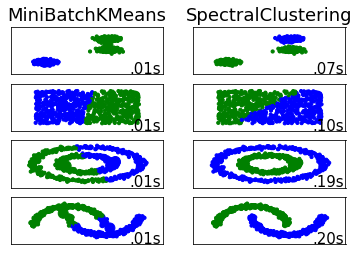

In [45]:
plot_num = 1
n_clusters=2

# Aplicamos los clusters para la comparacion
datasets = [blobs, no_structure,noisy_circles, noisy_moons]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset

    # Normalizar datos para un facil selecion de parametros
    X = StandardScaler().fit_transform(X)

    # Una forma de llegar a tu matris de similitud, generando una matriz de conectividad entre los puntos
    connectivity = kneighbors_graph(X, n_neighbors=10)
    # conectividad simetrica
    connectivity = 0.5 * (connectivity + connectivity.T)

    # calculando distancias
    distances = euclidean_distances(X)

    # instaciando Cluster (K-means y Spectral Clustering)
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity='nearest_neighbors',
                                          assign_labels='discretize')
    


    for algorithm in [two_means, spectral]:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        pl.subplot(4, 2, plot_num)
        if i_dataset == 0:
            pl.title(str(algorithm).split('(')[0], size=18)
        pl.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            pl.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        pl.xlim(-2.5, 2.5)
        pl.ylim(-2.5, 2.5)
        pl.xticks(())
        pl.yticks(())
        pl.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                transform=pl.gca().transAxes, size=15,
                horizontalalignment='right')
        plot_num += 1

pl.show()

## Mostrando Eigen Vectores

In [46]:
import numpy as np
from sklearn.feature_extraction import image
from sklearn.manifold import SpectralEmbedding

vamos a construir los circulos que seran usados, para usar la funcion espectral para ver la iteracion de los Eigen vectores.

In [47]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2 = 16, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2

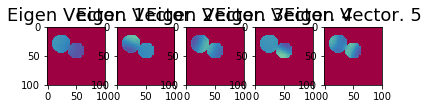

In [48]:
# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.1 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

se = SpectralEmbedding(n_components=5,affinity='precomputed')

Y = se.fit_transform(graph.toarray())

for j in range(0,se.n_components):
    pl.subplot(1,se.n_components, j+1)
    label_im = -np.ones(mask.shape)
    label_im[mask] = Y[:,j]
    pl.title('Eigen Vector. %i' % (j+1), size=18)
    pl.imshow(label_im,cmap=pl.cm.Spectral)
pl.show()
pl.figure()
pl.scatter(Y[:, 1], Y[:, 2], c=Y[:,0], cmap=pl.cm.Spectral)

# Aplicacion de Spectral Clustering

In [49]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version
from PIL import Image, ImageOps

In [52]:

img2 = Image.open('lena.png')  # Se abre la imagen PNG
grises = ImageOps.grayscale(img2)

# Para agilizar el procesamiento de la imagen se reduce el tamaño al 50%
grises = sp.misc.imresize(grises, 0.50) / 255.

# Convertimos la imagen en un grafo con valores de la gradiente en las aristas.
graph = image.img_to_graph(grises)

# Definimos un parametro beta, mientras mas pequeño sea ese valor la segmentacion es mas independiente
beta = 7
eps = 1e-6

# Usamos la funcion decreciente de la gradiente (exponencial)
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Numero de regiones a segmentar
N_REGIONS = 25

In [ ]:
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    labels = labels.reshape(grises.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(grises, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()

Spectral clustering: kmeans, 134.20s
